In [25]:
import pandas as pd 

opt1 = 'Model A is much fairer'
opt2 = 'Model A fairer'
opt3 = 'Don\'t know'
opt4 = "Model B is fairer"
opt5 = 'Model B is much fairer'

#Loading data
data = pd.read_csv("../data/output/Batch_281400_batch_results.csv")

#Calculating average task time 
worker_ids = data["WorkerId"]
t = data["WorkTimeInSeconds"]

avg_t = 0
worker_t = []
worker_t_index = []

for i in range(len(t)):
    avg_t += t[i]
    if worker_ids[i] in worker_t_index:
        index = worker_t_index.index(worker_ids[i])
        worker_t[index] += t[i]
    else:
        worker_t_index.append(worker_ids[i])
        worker_t.append(t[i])
    
avg_t = avg_t / len(t)

print("The average finish time of a task: " + str(avg_t))


#Calculating average time to complete all tasks
avg_t = 0
for t_i in worker_t:
    avg_t += t_i
avg_t = avg_t / len(t)

print("The average finish time of a HIT: " + str(avg_t))

test_types = []
tests = []
answers = data["Answer.category.label"]
inputs = data["Input.Identity"]

for i in range(len(inputs)):
    netherlands = data["Answer.country.1"][i]
    finland = data["Answer.country.2"][i]
    taiwan = data["Answer.country.3"][i]

    country = ""
    if netherlands:
        country = "Netherlands"
    if finland:
        country = "Finland"
    if taiwan:
        country = "Taiwan"

    asian = data["Answer.race.1"][i]
    black = data["Answer.race.2"][i]
    white = data["Answer.race.3"][i]

    race = ""
    if asian:
        race = "Asian"
    if black:
        race = "Black"
    if white:
        race = "White"
        
    if inputs[i] in test_types:
        index = test_types.index(inputs[i])
        tests[index].append((answers[i],country, race))
    else:
        test_types.append(inputs[i])
        tests.append([(answers[i],country, race)])

#Filtering out test according to the quality control
#The test with the golden question
golden_test = 3
#The tests that are shuffled version of the same models ()
same_model_1 = 0
same_model_2 = 2

num_tests = len(tests)
num_data = len(tests[0])

filtered_tests = []
for i in range(num_tests):
    filtered_tests.append([])
    
for i in range(num_data):
    if tests[golden_test][i][0] == opt4 and tests[same_model_1][i][0] == tests[same_model_2][i][0]:
        for j in range(num_tests):
            filtered_tests[j].append(tests[j][i]) 

#Uncomment to add quality control
tests = filtered_tests

#Calculating the amount of data that should be filtered out
print("The amount of data filtered out: " + str(num_data-len(tests[0])))
num_data = len(tests[0])

#Calculating the number of don't know answers
counts = [0] * num_tests
for i in range(num_tests):
    for j in range(num_data):
        if tests[i][j][0] == opt3:
            counts[i] += 1

for i in range(num_tests):              
    print("The average number of don't know answers for a task " + test_types[i] + ": " + str(counts[i]/num_data))

avg_dont_know = 0
for i in range(num_tests):
    avg_dont_know += counts[i]
               
avg_dont_know = avg_dont_know / num_data

print("The average number of don't know answers of a HIT: " + str(avg_dont_know))



5
5
The average finish time of a task: 81.4
The average finish time of all of the tasks: 81.4
The amount of data filtered out: 0
The average number of don't know answers for a task Taiwanese: 0.0
The average number of don't know answers for a task Dutch: 0.0
The average number of don't know answers for a task White: 0.0
The average number of don't know answers for a task Finnish: 0.0
The average number of don't know answers for a task Chinese: 0.0
The average number of don't know answers for all of the tasks: 0.0


In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#Function for plotting the fairness of models according to workers 
def plot_fairness(j, filt_country, filt_race):
    prefer_A = 0
    prefer_A_l = 0
    dont_know = 0
    prefer_B_l = 0
    prefer_B = 0

    num_passed = 0
    for i in range(num_data):
        pass_country = True
        if filt_country:
            pass_country = False
            for filt in filt_country:
                if tests[j][i][1] == filt:
                    pass_country = True             
        
        pass_race = True
        if filt_race:
            pass_race = False        
            for filt in filt_race:
                if tests[j][i][2] == filt:
                    pass_race = True      
            
        if pass_country and pass_race:
            num_passed += 1
            x = tests[j][i][0]
            if x == opt1:
                prefer_A += 1 
            if x == opt2:
                prefer_A_l += 1
            if x == opt3:
                dont_know += 1
            if x == opt4:
                prefer_B_l += 1
            if x == opt5:
                prefer_B += 1

    prefer_A = prefer_A / num_passed
    prefer_A_l = prefer_A_l / num_passed
    dont_know = dont_know / num_passed
    prefer_B_l = prefer_B_l / num_passed
    prefer_B = prefer_B / num_passed
    
    #print(prefer_A)
    #print(prefer_A_l)
    #print(dont_know)
    #print(prefer_B_l)
    #print(prefer_B)

    fig, ax = plt.subplots()
    ax.broken_barh([(0, prefer_A), 
                    (prefer_A, prefer_A+prefer_A_l), 
                    (prefer_A+prefer_A_l, 
                     prefer_A+prefer_A_l+dont_know),
                    (prefer_A+prefer_A_l+dont_know, 
                     prefer_A+prefer_A_l+dont_know+prefer_B_l),
                    (prefer_A+prefer_A_l+dont_know+prefer_B_l,
                     prefer_A+prefer_A_l+dont_know+prefer_B_l+prefer_B)], [10, 9], 
                     facecolors=('#6259D8', '#E53F08', '#FDB200', '#3FE03D', '#1EE8D4'))

    ax.set_ylim(5, 15)
    ax.set_xlim(0, 1)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks([15, 25])
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])

    ax.set_axisbelow(True) 

    ax.set_yticklabels(['Test ' + str(j+1)])
    ax.grid(axis='x')
    
    
    fig.suptitle('Fairness Test ' + str(j+1), fontsize=16)

    leg1 = mpatches.Patch(color='#6259D8', label='Model A is much fairer')
    leg2 = mpatches.Patch(color='#E53F08', label='Model A fairer')
    leg3 = mpatches.Patch(color='#FDB200', label='Don\'t know')
    leg4 = mpatches.Patch(color='#3FE03D', label='Model B is fairer')
    leg5 = mpatches.Patch(color='#1EE8D4', label='Model B is much fairer')
    ax.legend(handles=[leg1, leg2, leg3, leg4, leg5], ncol=2)

    plt.show()
    

In [63]:
import sklearn.metrics as met

def calculate_agreement(filt_country, filt_race, filt_country2, filt_race2):
    test1 = []
    for j in range(num_tests):
        test = []
        for i in range(num_data):
            pass_country = True
            if filt_country:
                pass_country = False
                for filt in filt_country:
                    if tests[j][i][1] == filt:
                        pass_country = True             

            pass_race = True
            if filt_race:
                pass_race = False        
                for filt in filt_race:
                    if tests[j][i][2] == filt:
                        pass_race = True 

            if pass_country and pass_race:
                test.append(tests[j][i][0])
        test1.append(test)
        
                
            
    test2 = []
    for j in range(num_tests):
        test = []
        for i in range(num_data):
            pass_country = True
            if filt_country:
                pass_country = False
                for filt in filt_country2:
                    if tests[j][i][1] == filt:
                        pass_country = True             

            pass_race = True
            if filt_race:
                pass_race = False        
                for filt in filt_race2:
                    if tests[j][i][2] == filt:
                        pass_race = True 

            if pass_country and pass_race:
                test.append(tests[j][i][0])
        test2.append(test)
    
    agreement_score = 0
    num_comparisons = 0
    for i in range(len(test1[0])):
        for j in range(len(test2[0])):
            agreement_score += met.cohen_kappa_score(test1[:][i], test2[:][j], labels=[opt1,opt2,opt2,opt4,opt5])
            num_comparisons += 1
                   
    agreement_score = agreement_score/num_comparisons    
                   
    print("The average inter annotator score between people with the following demographics" 
          + str(filt_country) + str(filt_race) + " and " +  str(filt_country2) + str(filt_race2) 
          + ": " + str(agreement_score))

The average inter annotator score between people with the following demographics[][] and [][]: nan


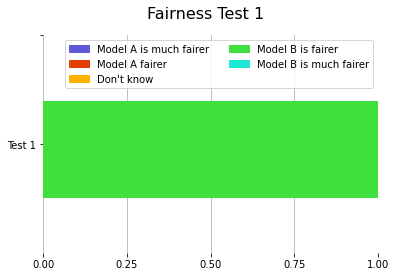

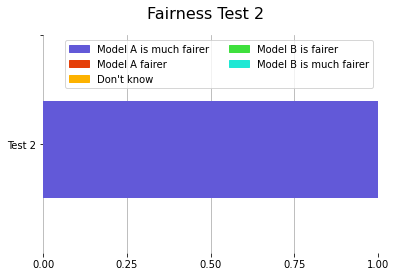

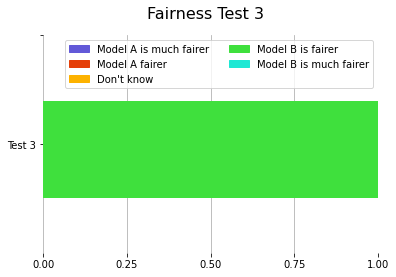

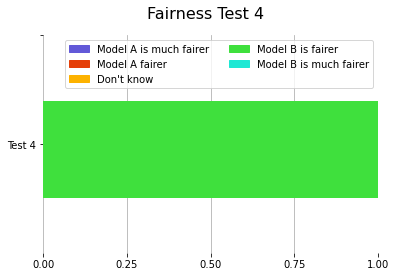

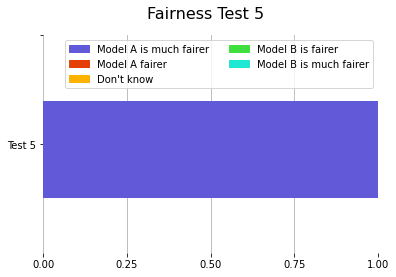

In [64]:
calculate_agreement([], [], [], [])

#Plot for all people
for j in range(num_tests):
    plot_fairness(j, [], [])

In [34]:
#Plot for Finnish Christian
#To filter out demographics: 
#the first list is to only allow people from certain countries
#the second list is to only allow people with certain religions
#the third list is to only allow people with certain races
#Empty lists means every demograhic is allowed
for j in range(num_tests):
    plot_fairness(j, ["Finland"], [])


ZeroDivisionError: division by zero